In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix
from scipy.stats import spearmanr as spearman
pilot_file = "Batch_3220834_batch_results.csv"
sid_pilot_file = "Batch_193054_batch_results_sid.csv"

In [2]:
data = pd.read_csv(pilot_file)
data.columns = [c.replace('.', '_') for c in data.columns]

#data.head()

In [3]:
data.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input_var_arrays',
       'Answer_comments', 'Answer_confidence_range1',
       'Answer_confidence_range10', 'Answer_confidence_range2',
       'Answer_confidence_range3', 'Answer_confidence_range4',
       'Answer_confidence_range5', 'Answer_confidence_range6',
       'Answer_confidence_range7', 'Answer_confidence_range8',
       'Answer_confidence_range9', 'Answer_dummy', 'Answer_sld_pred1_1',
       'Answer_sld_pred1_10', 'Answer_sld_pred1_2', 'A

In [4]:
def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_pred1 = "Answer_sld_pred1_" + str(idx+1)
            var_pred2 =  "Answer_sld_pred2_" + str(idx+1)
            var_conf = "Answer_confidence_range" + str(idx+1)
            
            temp_dict["slider1_posn"] = getattr(row, var_pred1)
            temp_dict["slider2_posn"] = getattr(row, var_pred2)
            temp_dict["confidence"] = getattr(row, var_conf)
            temp_dict["worker_id"] = row.WorkerId
            temp_dict["hit_id"] = row.HITId

            global_list.append(temp_dict)
            
    return pd.DataFrame(global_list)

In [5]:
pilot_data = extract_dataframe(data)

#Re-arrange the order 
cols = list(pilot_data.columns)
#pilot_data = pilot_data[pilot_data.columns[::-1]].drop('sentence', axis=1)
pilot_data = pilot_data[pilot_data.columns[::-1]]


#Drop start, end, instant variables that were stored in the json data
pilot_data = pilot_data.drop(['start_pred1', 'start_pred2', 'end_pred1', 'end_pred2',
                             'instant_pred1', 'instant_pred2'], axis=1)


#pilot_data.replace('na',np.NaN, inplace=True)
pilot_data.head
pilot_data['sent_token'] = pilot_data['sentence_id'] + "_" +\
                            pilot_data['pred_token1'].map(lambda x: str(x)) + "_" +\
                             pilot_data['pred_token2'].map(lambda x: str(x))

In [6]:
print(pilot_data.shape)
pilot_data.head()

(500, 13)


,worker_id,slider2_posn,slider1_posn,sentence_id,sentence,pred_token2,pred_token1,pred2,pred1,id,hit_id,confidence,sent_token
0,AURYD2FH3FUOQ,27 - 46,39 - 46,en-ud-train.conllu 13,"On Wednesday guerrillas had <span class=\""pre...",16,4,way,kidnapped,1,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,3,en-ud-train.conllu 13_4_16
1,AURYD2FH3FUOQ,6 - 17,25 - 41,en-ud-train.conllu 46,Yesterday there were tens of them <span class...,26,6,leave,putting,2,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,1,en-ud-train.conllu 46_6_26
2,AURYD2FH3FUOQ,19 - 26,35 - 37,en-ud-train.conllu 60,"He did once <span class=\""predicate\""> make</...",14,3,shooting,make,3,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,0,en-ud-train.conllu 60_3_14
3,AURYD2FH3FUOQ,57 - 80,35 - 36,en-ud-train.conllu 65,"He <span class=\""predicate\""> added</span> t...",57,1,dragged,added,4,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,2,en-ud-train.conllu 65_1_57
4,AURYD2FH3FUOQ,15 - 16,10 - 16,en-ud-train.conllu 118,"As a child in the 50&#39;s I <span class=\""pr...",34,7,started,had,5,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,2,en-ud-train.conllu 118_7_34


In [7]:
def time_ml_tag(row, var1, var2):
    '''
    Creates time ML tags from slider positions of two events 
    
    Eg: EVENT 1 "is before" EVENT2
    
    Eg: Relatins: is before
    '''
    ans = ""
    
    slider1 = getattr(row, var1)
    slider2 = getattr(row, var2)
    
    event1 = [int(x) for x in slider1.split("-")]
    event2 = [int(x) for x in slider2.split("-")]
    
    if (event1[0] == event2[0]) and (event1[1] == event2[1]):
        ans = "simultaneous"
        
    elif event1[1] <= event2[0]:
        ans = "before"
    
    elif event1[0] >= event2[1]:
        ans = "after"
        
    elif event1[1] >= event2[1] and event1[0] <= event2[0]:
        ans = "includes"
        
    elif event1[1] <= event2[1] and event1[0] >= event2[0]:
        ans = "is_included"
    
    elif event1[0] < event2[0] and event1[1] > event2[0]:
        ans = "before_cont"
        
    elif event1[0] < event2[1] and event1[1] > event2[1]:
        ans = "after_cont"
    
    else: 
        ans = "other"
    
    return ans

In [8]:
pilot_data['timeML_tag'] = pilot_data.apply(lambda row: time_ml_tag(row, 'slider1_posn', 'slider2_posn'), axis=1)

before          263
after            73
includes         60
is_included      56
simultaneous     23
before_cont      14
after_cont       11
Name: timeML_tag, dtype: int64


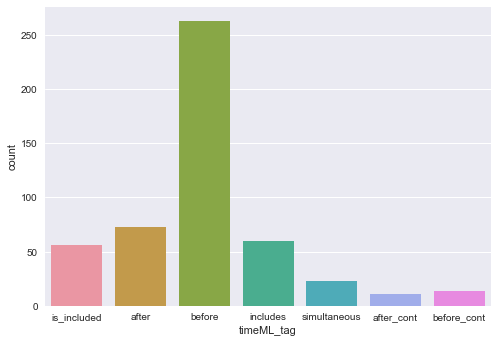

In [9]:
print(pilot_data.timeML_tag.value_counts())
sns.countplot(x='timeML_tag', data=pilot_data)
plt.show()


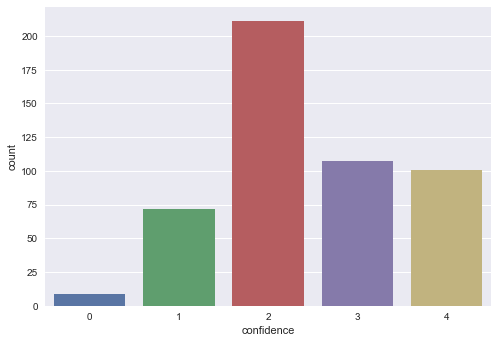

In [10]:
sns.countplot(x='confidence', data=pilot_data)
plt.show()

## Inter-Annotator Agreement

#### Raw Agreement

In [11]:
def calc_raw_agreement(data, key_var, check_var, degree=5):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    4. degree: Degree to which annotators agree: 
                5 means all annotators had the same answer
                4 means >=4 annotators had the same answer
                3 means >=3 annotators had the same answer
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(list(data[key_var].values))

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(max(set(temp), key=temp.count)) >= degree:
                raw_count += 1
                keys.append(iden)

    agreement = (raw_count/total_count)*100
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys



In [12]:
a1, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'timeML_tag', degree=5)
print("\n")
a2, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'timeML_tag', degree=4)
print("\n")
a3, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'timeML_tag', degree=3)
print("\n")
a4, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'timeML_tag', degree=2)

####### Raw Count for timeML_tag ###########
Total count of unique sent_token is 100
Raw count of matched for timeML_tag is 22
Inter-annotator agreement for timeML_tag is 22.0%




####### Raw Count for timeML_tag ###########
Total count of unique sent_token is 100
Raw count of matched for timeML_tag is 34
Inter-annotator agreement for timeML_tag is 34.0%




####### Raw Count for timeML_tag ###########
Total count of unique sent_token is 100
Raw count of matched for timeML_tag is 70
Inter-annotator agreement for timeML_tag is 70.0%




####### Raw Count for timeML_tag ###########
Total count of unique sent_token is 100
Raw count of matched for timeML_tag is 98
Inter-annotator agreement for timeML_tag is 98.0%




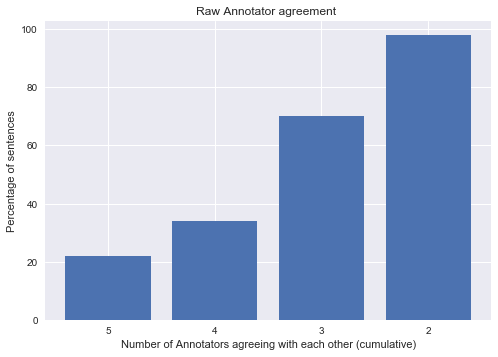

In [13]:
agrees = [a1, a2, a3, a4]
degree = ['5', '4', '3', '2']

plt.bar(degree, agrees)
plt.xlabel("Number of Annotators agreeing with each other (cumulative)")
plt.ylabel("Percentage of sentences")
plt.title("Raw Annotator agreement ")
plt.show()

### Kappa estimation 

In [14]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def extract_worker_pair_dict(data, worker_pairs, worker_dict, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    ans = {}
    
    for (w1, w2) in worker_pairs:
        common_set = worker_dict[w1].intersection(worker_dict[w2])
        if common_set != set():
            ans[(w1,w2)] = list(common_set)
        
    return ans

In [15]:
worker_pairs = extract_pairs_of_workers(pilot_data, 'worker_id')
worker_dict = extract_worker_sent_dict(pilot_data, 'worker_id', 'sent_token')
worker_pair_dict = extract_worker_pair_dict(pilot_data, worker_pairs, worker_dict,'sent_token')

In [16]:
def average_metric_sklearn(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, accuracy and spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    kappas = []
    accuracies = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []
        
        for key in common_set:
            val3 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val4 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values 
            temp1.append(val3[0])
            temp2.append(val4[0])
                   
        if temp1 == [] or temp2 == []:
            continue

        elif temp1==temp2:
            kappas.append(1.0)
        else:
            kappas.append(kappa(temp1, temp2))
        accuracies.append(accuracy(temp1, temp2))
                
    return kappas, accuracies

In [17]:
kappas = {}
accuracies = {}
vars_temp = ['timeML_tag']
for var in vars_temp:
    kappas[var], accuracies[var] = average_metric_sklearn(pilot_data, 'worker_id', 'sent_token', var)
    print("{} -- Completed!".format(var))

timeML_tag -- Completed!


In [18]:
kappa_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in kappas.items() ]))
acc_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in accuracies.items() ]))

In [19]:
print('Average Kappa for "timeML_tag" variable: {}'.format(np.mean(kappa_data['timeML_tag'])))
print("\n")

print('Average Accuracy for "timeML_tag" variable: {}'.format(np.mean(acc_data['timeML_tag'])))
print("\n")

Average Kappa for "timeML_tag" variable: 0.18573327643520413


Average Accuracy for "timeML_tag" variable: 0.44541139240506356




## Confusion Matrix

In [20]:
time_tags = list(pilot_data.timeML_tag.unique())

In [21]:
time_tags

['is_included',
 'after',
 'before',
 'includes',
 'simultaneous',
 'after_cont',
 'before_cont']

In [22]:
def average_confusion_matrix(data, worker_id, key_var, check_var, time_tags):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, accuracy and spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    conf_list = []
    conf_rev_list = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []
        
        for key in common_set:
            val3 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val4 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values 
            temp1.append(val3[0])
            temp2.append(val4[0])
                   
        if temp1 == [] or temp2 == []:
            continue

        conf_matrix = confusion_matrix(temp1, temp2, labels=time_tags)
        conf_matrix_rev = confusion_matrix(temp2, temp1, labels=time_tags)
        
        #NORMALISE
        sum_a = np.sum(conf_matrix,axis=None)
        sum_rev = np.sum(conf_matrix_rev,axis=None)
        
        conf_matrix = conf_matrix/sum_a
        conf_matrix_rev = conf_matrix_rev/sum_rev
        
        conf_list.append(conf_matrix)
        conf_rev_list.append(conf_matrix_rev)
        
                
    return conf_list, conf_rev_list

In [23]:
conf_list, conf_rev_list = average_confusion_matrix(pilot_data, 'worker_id', 'sent_token', 'timeML_tag', time_tags)

In [24]:
def matprint(mat, fmt="g"):
    '''
    Source: https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    '''
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [25]:
sum_final = sum(conf_list)/len(conf_list)
sum_rev_final = sum(conf_rev_list)/len(conf_rev_list)

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '{0:f}'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




Normalized confusion matrix
[[0.30223881 0.07929104 0.41044776 0.11940299 0.03731343 0.02891791
  0.02238806]
 [0.11065183 0.35739269 0.3745628  0.06391097 0.02480127 0.02861685
  0.04006359]
 [0.05499542 0.05614115 0.70130614 0.10380385 0.01856095 0.01649863
  0.04869386]
 [0.18624044 0.06879778 0.48644892 0.15288395 0.07505212 0.00833912
  0.02223767]
 [0.17153996 0.04678363 0.42300195 0.22612086 0.10916179 0.
  0.02339181]
 [0.13065327 0.08040201 0.52763819 0.18090452 0.04020101 0.
  0.04020101]
 [0.16289593 0.16289593 0.43891403 0.12669683 0.05429864 0.05429864
  0.        ]]


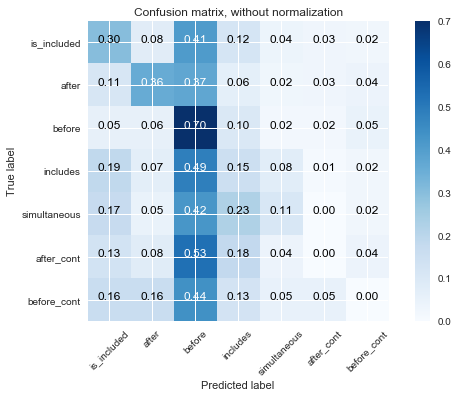

In [27]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(sum_final, classes=time_tags, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()

Normalized confusion matrix
[[0.27715997 0.14884517 0.20530368 0.22925577 0.07527802 0.03336185
  0.03079555]
 [0.07906977 0.5227907  0.22790698 0.09209302 0.02232558 0.02232558
  0.03348837]
 [0.08363429 0.1119559  0.58173351 0.13305455 0.04124691 0.02993727
  0.01843756]
 [0.11641655 0.09140518 0.41200546 0.20009095 0.1055025  0.04911323
  0.02546612]
 [0.11494253 0.11206897 0.23275862 0.31034483 0.16091954 0.03448276
  0.03448276]
 [0.18023256 0.26162791 0.41860465 0.06976744 0.         0.
  0.06976744]
 [0.06751055 0.17721519 0.59774965 0.09001406 0.03375527 0.03375527
  0.        ]]


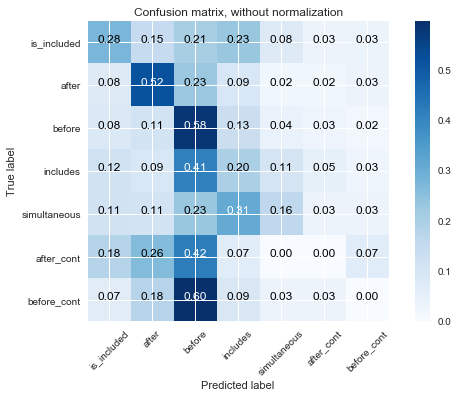

In [28]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(sum_rev_final, classes=time_tags, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()

#### Sid's predictions

In [29]:
sid_data = pd.read_csv(sid_pilot_file)
sid_data.columns = [c.replace('.', '_') for c in sid_data.columns]

sid_pilot_data = extract_dataframe(sid_data)

#Re-arrange the order 
cols = list(sid_pilot_data.columns)
#sid_pilot_data = sid_pilot_data[sid_pilot_data.columns[::-1]].drop('sentence', axis=1)
sid_pilot_data = sid_pilot_data[sid_pilot_data.columns[::-1]]


#Drop start, end, instant variables that were stored in the json data
sid_pilot_data = sid_pilot_data.drop(['start_pred1', 'start_pred2', 'end_pred1', 'end_pred2',
                             'instant_pred1', 'instant_pred2'], axis=1)


#pilot_data.replace('na',np.NaN, inplace=True)
sid_pilot_data['sent_token'] = sid_pilot_data['sentence_id'] + "_" +\
                            sid_pilot_data['pred_token1'].map(lambda x: str(x)) + "_" +\
                             sid_pilot_data['pred_token2'].map(lambda x: str(x))
sid_pilot_data.head()

,worker_id,slider2_posn,slider1_posn,sentence_id,sentence,pred_token2,pred_token1,pred2,pred1,id,hit_id,confidence,sent_token
0,A2GL712W3LDMFO,32 - 73,45 - 60,en-ud-train.conllu 13,"On Wednesday guerrillas had <span class=\""pre...",16,4,way,kidnapped,1,35A1YQPVFEGOK6YXHVHV03G0I0CI51,4,en-ud-train.conllu 13_4_16
1,A2GL712W3LDMFO,22 - 43,52 - 100,en-ud-train.conllu 46,Yesterday there were tens of them <span class...,26,6,leave,putting,2,35A1YQPVFEGOK6YXHVHV03G0I0CI51,1,en-ud-train.conllu 46_6_26
2,A2GL712W3LDMFO,20 - 34,42 - 46,en-ud-train.conllu 60,"He did once <span class=\""predicate\""> make</...",14,3,shooting,make,3,35A1YQPVFEGOK6YXHVHV03G0I0CI51,2,en-ud-train.conllu 60_3_14
3,A2GL712W3LDMFO,44 - 51,28 - 34,en-ud-train.conllu 65,"He <span class=\""predicate\""> added</span> t...",57,1,dragged,added,4,35A1YQPVFEGOK6YXHVHV03G0I0CI51,2,en-ud-train.conllu 65_1_57
4,A2GL712W3LDMFO,41 - 47,13 - 41,en-ud-train.conllu 118,"As a child in the 50&#39;s I <span class=\""pr...",34,7,started,had,5,35A1YQPVFEGOK6YXHVHV03G0I0CI51,2,en-ud-train.conllu 118_7_34


before          36
after           21
simultaneous    13
is_included      5
includes         5
Name: timeML_tag, dtype: int64


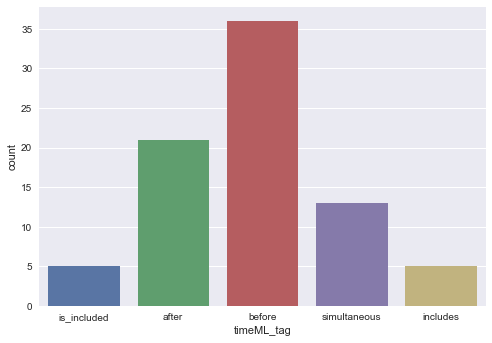

In [30]:
sid_pilot_data['timeML_tag'] = sid_pilot_data.apply(lambda row: time_ml_tag(row, 'slider1_posn', 'slider2_posn'), axis=1)
print(sid_pilot_data.timeML_tag.value_counts())
sns.countplot(x='timeML_tag', data=sid_pilot_data)
plt.show()

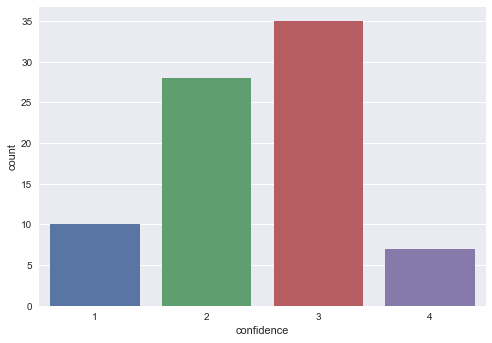

In [31]:
sns.countplot(x='confidence', data=sid_pilot_data)
plt.show()

### Manual Analysis of Sentences

In [32]:
#sid_pilot_data[sid_pilot_data.confidence==3]

In [33]:
#pilot_data[pilot_data.sent_token == "en-ud-train.conllu 11663_17_28"]

#### Examples with high confidence as per Sid:
 -  '&lsqb; an error  <span class=\\"predicate\\"> ** occurred **</span>  while  <span class=\\"predicate\\"> ** processing **</span>  this directive &rsqb;'

    my tag: is_included, 3/5 match , others - before, after
    
    
- 'Meanwhile , President George W Bush has  <span class=\\"predicate\\"> ** said **</span>  he will lead an inquiry into how the disaster was  <span class=\\"predicate\\"> ** handled **</span>  .'

    my tag: after, 3/5 match , others - is_included, before
    
    
- 'We then called the office and the man we spoke to  <span class=\\"predicate\\">** said **</span>  he &#39;d send someone out to look at it but could n&#39;t promise when - two weeks came and went and we  <span class=\\"predicate\\">** heard **</span>  nothing .'

    my tag: before, 5/5 match
    
   
- 'Well last night while I was  <span class=\\"predicate\\">** sleeping **</span>  , my hamster  <span class=\\"predicate\\">** escaped **</span>  from his cage .'

    my tag: includes, 3/5 match, others - before(4,2)
    
    
-  'Phone calls were n&#39;t returned when promised and the botched repair  <span class=\\"predicate\\"> ** took **</span>  a week longer than  <span class=\\"predicate\\">** promised **</span>  .'
    
      my tag: after, 5/5 match

#### Intriguing examples

- 'Right now , while we &#39;re  <span class=\\"predicate\\">** sitting **</span>  at our computers enjoying the internet , those innocent , beautiful , loving cats , are  <span class=\\"predicate\\">** dying **</span>  , somewhere in this troubled world a slow , agonizing death .'

    my tag - simultaneous, 2/5 match: others: (before-2 conf, after-2 conf, includes-3 conf)
    
    
- 'I did n&#39;t expect to react that way , but when I was  <span class=\\"predicate\\">** looking **</span>  around my workplace in Nashua , New Hampshire , and everyone else looked pretty much like me , it was really very  <span class=\\"predicate\\">** eerie **</span>  .'

    my tag - simultaneous, 0/5 match; others: (before:4/5 annotators, includes:1/5 with 4 confidence)
    
    
- 'Finally a chambermaid  <span class=\\"predicate\\">** stuck **</span>  her head around the corner from the top of the stairs and  <span class=\\"predicate\\">** told **</span>  us sternly that we could not be accommodated until 3 M , no exceptions .'

    my tag - before, 3/5 match; others-(simultaneous with 4 rating, includes with 3 rating)
    
    
- 'We typically only  <span class=\\"predicate\\">** book **</span>  deals when everything is  <span class=\\"predicate\\">** signed **</span>  off .'

    2/5 : before (4, 2 conf)
    2/5 : after (2, 1 conf)
    1/5: after_cont (3 conf)
    
    
- 'From a moral standpoint , you guys are really gon na take 2,000 bucks from someone that  <span class=\\"predicate\\">**  needs **</span>  that truck to work and support his family when you  <span class=\\"predicate\\">** know **</span>  it s just a piece of scrap metal ?'

    2/5: before (2,2 conf)
    1/5: simultaneous (2 conf)
    1/5: includes (2 conf)
    1/5: after_cont (3 conf)
